# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import theano
import seaborn as sns
import numpy as np

from sklearn.preprocessing import scale
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm_notebook as tqdm
from IPython.utils import io

from Peony_box.src.peony_box_model import PeonyBoxModel
from Peony_box.src.acquisition_functions.functions import entropy_sampling
from Peony_box.src.utils import k_fold_corss_validation, auc_metrics
from Peony_visualization.src.peony_visualization import visualize_two_auc_evolutions

# Create a Dataset

In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

# Plot the Data

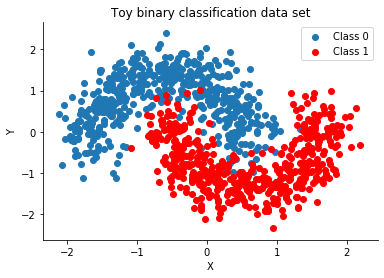

In [3]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

# Train The models

In [4]:
peony_model = PeonyBoxModel(None, active_learning_step=1)

In [5]:
peony_model.svm_model.fit(X_train, Y_train, False)
peony_model.random_forest_model.fit(X_train, Y_train, False)
peony_model.bayesian_nn.fit(X_train, Y_train, False)
peony_model.feed_forward_nn.fit(X_train, Y_train, False)
peony_model.bayesian_sgld_nn.fit(X_train, Y_train, False)

Average Loss = 165.9: 100%|██████████| 60000/60000 [00:41<00:00, 1460.10it/s] 
Finished [100%]: Average Loss = 165.96


[['starting loss is 0.7150342464447021',
  'fitted loss (samples mean) is 0.345885694026947']]

# Create the grid for classification

In [6]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).transpose()

# Get Predictions of grid for all models

In [7]:
svm_pred = peony_model.svm_model.predict(grid_2d, False)
random_forest_pred = peony_model.random_forest_model.predict(grid_2d, False)
bayesian_pymc3_pred = peony_model.bayesian_nn.predict(grid_2d, False)
feed_forward_nn_pred = peony_model.feed_forward_nn.predict(grid_2d, False)
bayesian_sgld_pred = peony_model.bayesian_sgld_nn.predict(grid_2d, False)

# Data With Algorithms Uncertainty Bounds

In [8]:
def plot_uncertainty_gird(prediction):
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    fig, ax = plt.subplots(figsize=(16, 9))
    contour = ax.contourf(grid[1], grid[0], prediction.reshape(100, 100).transpose(), cmap=cmap)
    ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
    ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
    cbar = plt.colorbar(contour, ax=ax)
    _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
    cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

## SVM

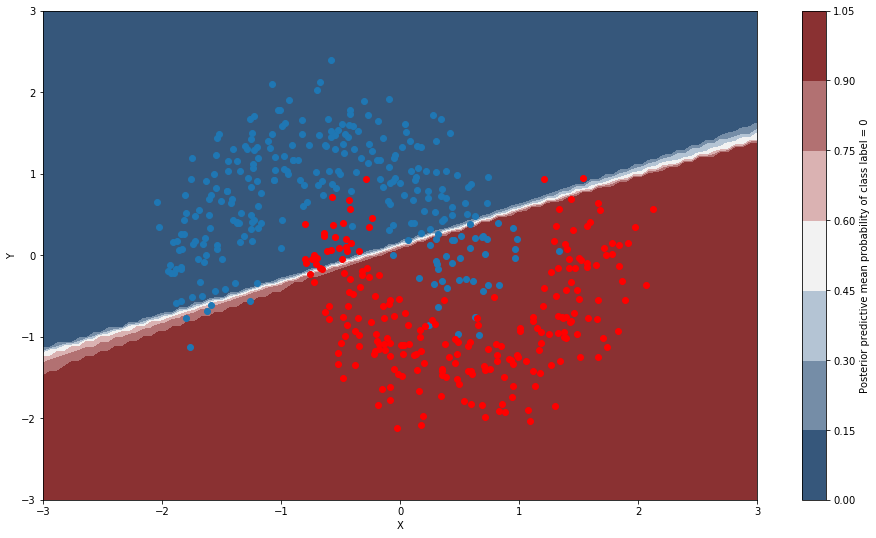

In [9]:
plot_uncertainty_gird(svm_pred)

## Random Forest

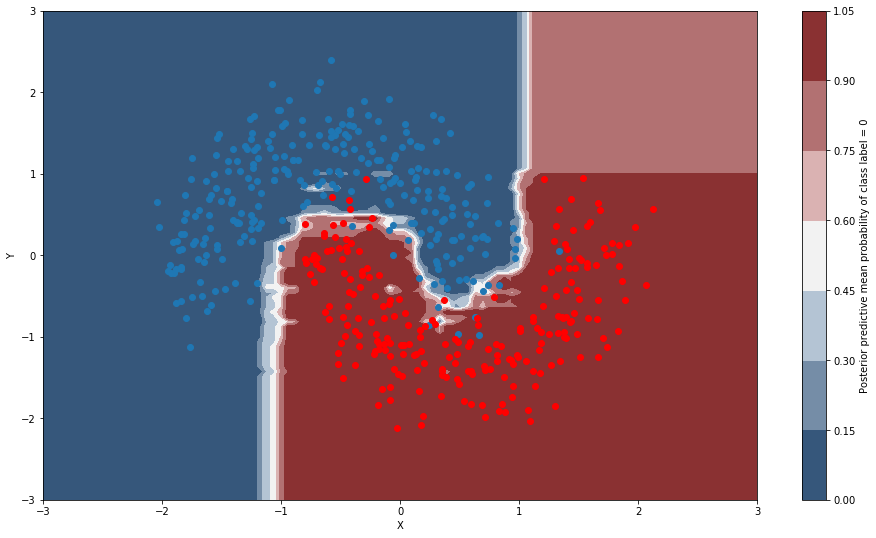

In [10]:
plot_uncertainty_gird(random_forest_pred)

## Feed Forward NN

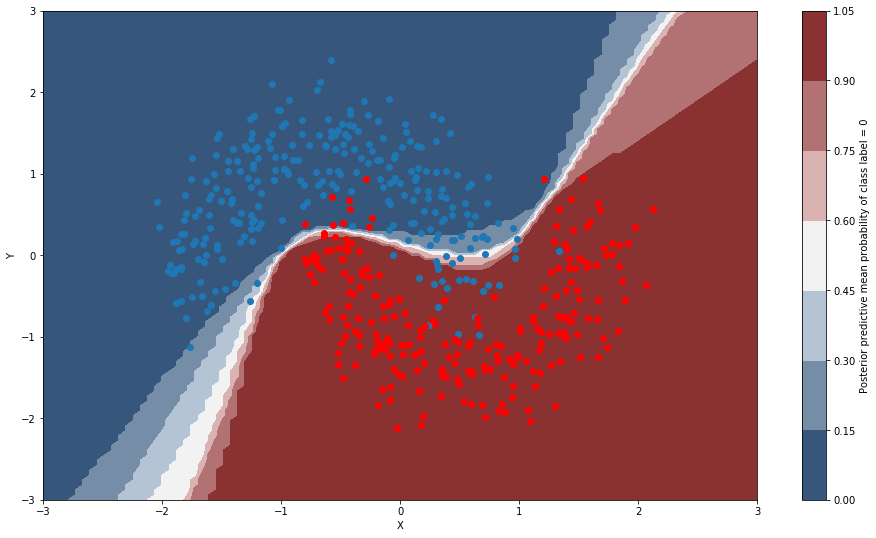

In [11]:
plot_uncertainty_gird(feed_forward_nn_pred)

## Bayesian PyMC3 Feed Forward NN

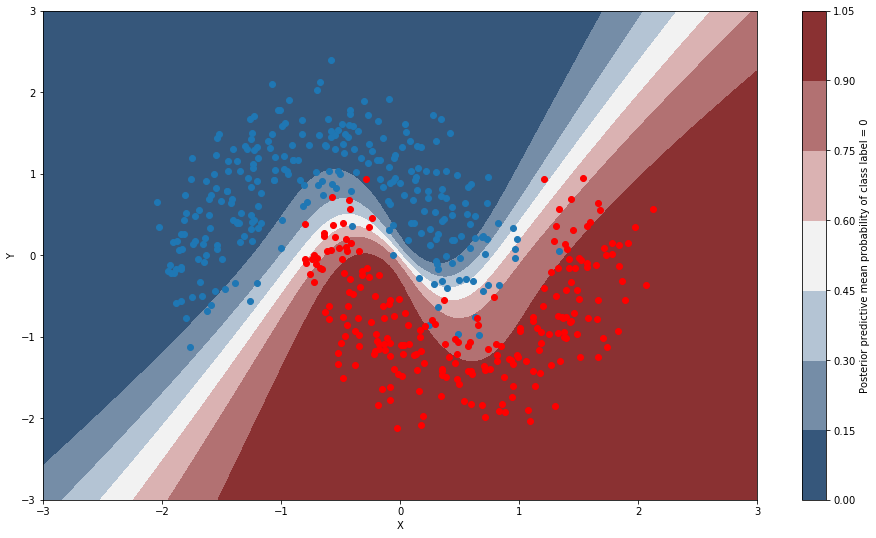

In [12]:
plot_uncertainty_gird(bayesian_pymc3_pred)

## Bayesian SGLD Feed Forward NN

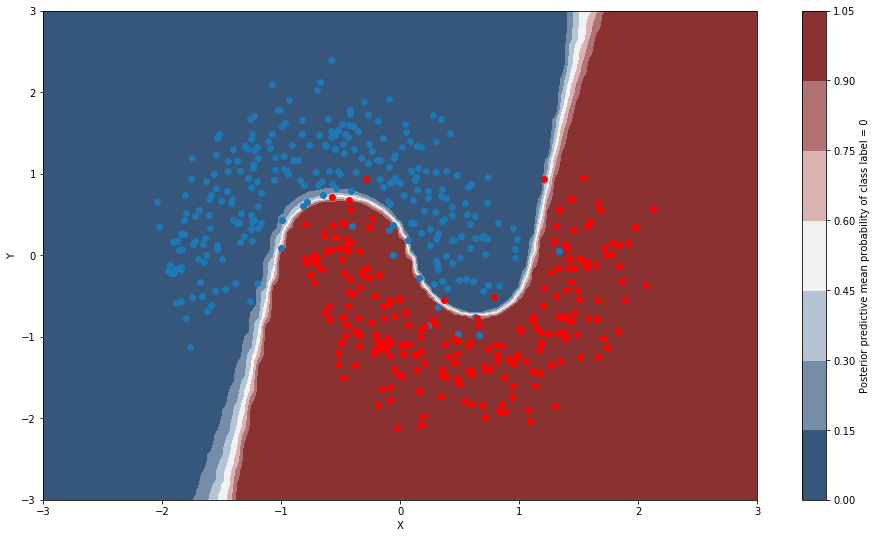

In [13]:
plot_uncertainty_gird(bayesian_sgld_pred)